# Texture-based separation to refine building meshes 

- Use Texture segmentation to separate the different materials in the meshes
- Detect the edges on the texture
- Convert the detected edges to hough lines
- project the uv coordinates of the mesh onto the plane
- Cut the triangles with the detected lines
- Define the new faces with the edge boundaries


In [1]:
%load_ext autoreload
%autoreload 2

from context import segmentationtools
import cv2
import open3d as o3d
import math
import numpy as np
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#import the 3D mesh
meshPath = "../../../localfiles/TestWall.obj"
mesh = o3d.io.read_triangle_mesh(meshPath, True)

## Texture Segmentation

- We want to group textures and reduce their detail for better edge detection
- use Factorisation based Texture segmentation


In [3]:
import segmentationtools.fseg as fseg

texture = np.asarray(mesh.textures[0])
grayTexture = cv2.resize(cv2.cvtColor(texture, cv2.COLOR_BGR2GRAY), (512, 512))

# define filter bank and apply to image. for color images, convert rgb to grey scale and then apply filter bank
filter_list = [('log', .5, [3, 3]), ('log', 1, [5, 5]),
                ('gabor', 1.5, 0), ('gabor', 1.5, math.pi/2), ('gabor', 1.5, math.pi/4), ('gabor', 1.5, -math.pi/4),
                ('gabor', 2.5, 0), ('gabor', 2.5, math.pi/2), ('gabor', 2.5, math.pi/4), ('gabor', 2.5, -math.pi/4)
                ]
filter_out = fseg.image_filtering(grayTexture, filter_list=filter_list)
# include original image as one band
Ig = np.concatenate((np.float32(grayTexture.reshape((grayTexture.shape[0], grayTexture.shape[1], 1))), filter_out), axis=2)
# run segmentation. try different window size, with and without nonneg constraints
segmentedTexture = fseg.Fseg(Ig, ws=20, segn=0, omega=0.2, nonneg_constraint=False)

[8.89606682e-08 1.41258738e-07 1.76979768e-07 2.03407637e-07
 2.22632835e-07 2.26324559e-07 2.26537679e-07 2.48772608e-07
 2.82316023e-07 3.35786126e-07 4.20948851e-07 5.25800203e-07
 7.15122269e-07 9.16584213e-07 1.13030683e-06 1.38772793e-06
 1.66432346e-06 1.97433019e-06 2.31849026e-06 2.74052377e-06
 3.21103494e-06 3.73661919e-06 4.32182696e-06 4.96314351e-06
 5.69515350e-06 6.53682628e-06 7.61671618e-06 8.93573815e-06
 1.03689508e-05 1.22333640e-05 1.41255168e-05 1.64239354e-05
 1.88178183e-05 2.13567619e-05 2.41377020e-05 2.73166479e-05
 3.10619907e-05 3.52343450e-05 3.99267992e-05 4.48936880e-05
 4.99145208e-05 5.51908925e-05 6.18609993e-05 6.88500513e-05
 7.62257696e-05 8.46326220e-05 9.37530203e-05 1.03464605e-04
 1.14232840e-04 1.26526225e-04 1.40275224e-04 1.55150803e-04
 1.70508894e-04 1.86764621e-04 2.06732759e-04 2.28080855e-04
 2.51440273e-04 2.81072716e-04 3.12784396e-04 3.49301030e-04
 3.92880989e-04 4.37706040e-04 4.83101874e-04 5.32468199e-04
 5.85974078e-04 6.431451

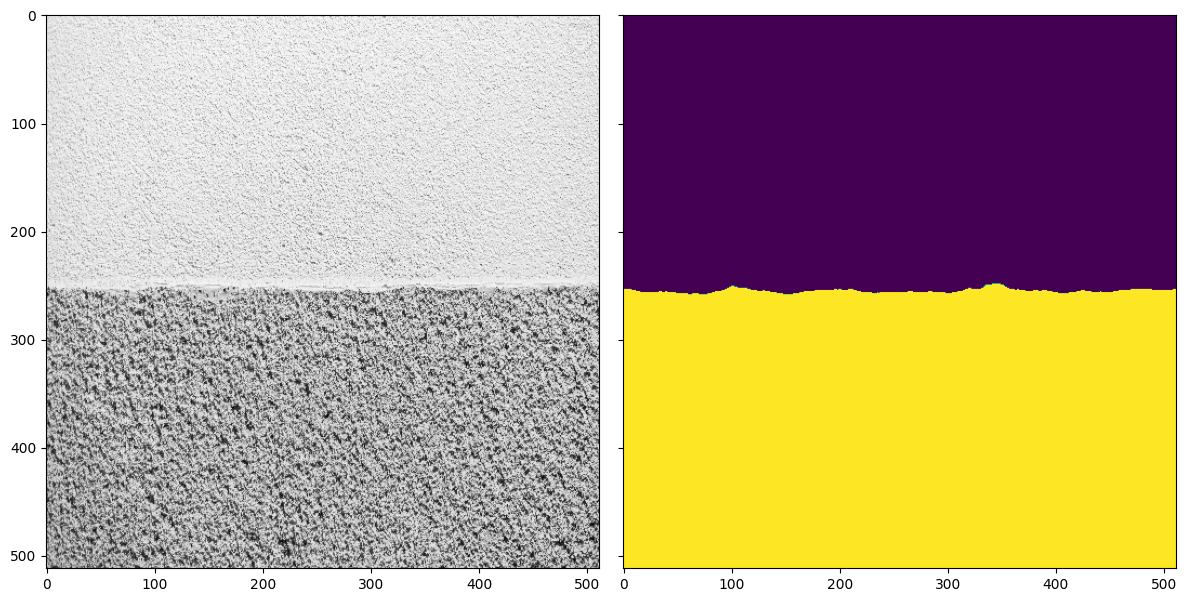

In [4]:
# show results
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 6))
ax[0].imshow(grayTexture, cmap='gray')
ax[1].imshow(segmentedTexture)
plt.tight_layout()
plt.show()

In [5]:

a = segmentedTexture
segmentedMappedTexture = np.round(np.interp(a, (a.min(), a.max()), (0, 255))).astype(np.uint8)


## Edge Detection

- The patched image is pefect to detect the boundaries of the textures
- Use canny or HED edge detection
- Find the hough lines to get straight lines in the dtected edges

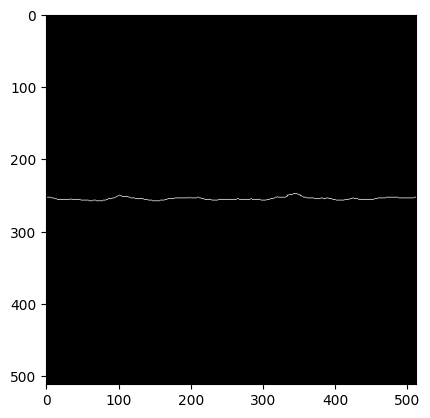

In [6]:
# perform Canny edge tedection to find sharp gradients
dst = cv2.Canny(segmentedMappedTexture, 100, 300, None, 3)
dstp = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

segmentationtools.show_img(dstp)

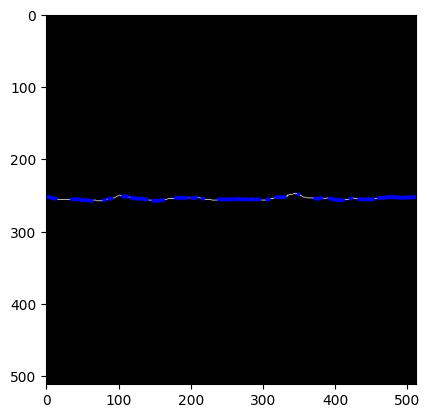

In [7]:
dstp2 = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
linesP = cv2.HoughLinesP(dst, 1, np.pi / 360, 30, None, 0, 0)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(dstp2, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

segmentationtools.show_img(dstp2)

[[[255.          1.5707964]]]


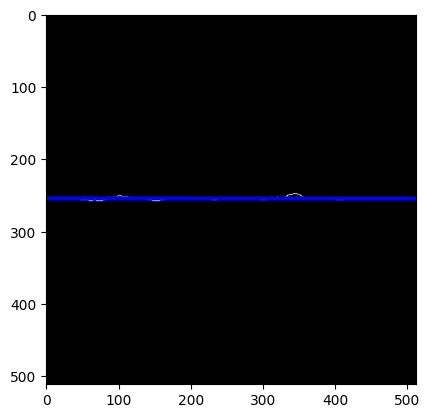

In [8]:
# Lets apply Standard HoughLine transform to detect lines
dstp2 = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
lines = cv2.HoughLines(dst, 2, np.pi / 120, 150, None, 0, 0)
print(lines)
# Below we will display the result by drawing lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv2.line(dstp2, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

segmentationtools.show_img(dstp2)

## Face Slicing

- slice the triangles that are in the path of the new lines
- check for continuity in adjacent faces to continue the line

### UV Plane Mapping

UV coordinates: 
 60
nr of vertices: 
 24


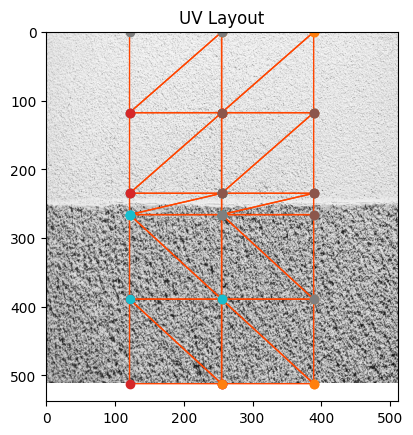

In [9]:
# Plot the triangles on the uv plane
# Scale the uv coordinates with the image dimensions
uvPoints = np.asarray(mesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
print("UV coordinates: \n", len(uvPoints))
print("nr of vertices: \n", len(mesh.vertices))
plt.imshow(grayTexture, cmap='gray')

for i in range((int)(len(uvPoints)/3)):
    plt.fill(*zip(*uvPoints[3*i:3*i+3]), facecolor='none', edgecolor='orangered', linewidth=1)
    plt.scatter(*zip(*uvPoints[3*i:3*i+3]))
plt.title('UV Layout')
plt.show()

### Finding the intersectionPoints (Optional)

The resulting intersection points are: 
 [[301.88468707 255.0000132 ]
 [255.02310181 255.00001115]
 [167.85111918 255.00000734]
 [120.98969269 255.00000529]
 [389.05703735 255.00001701]
 [301.88468707 255.0000132 ]
 [255.02310181 255.00001115]
 [167.85111918 255.00000734]]


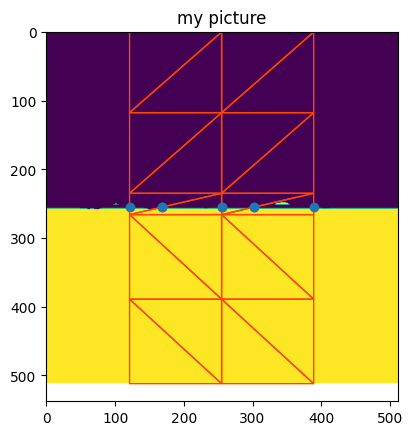

In [10]:
import segmentationtools as st
points = []

lineNr = 0

for i in range((int)(len(uvPoints)/3)):
    newPoints = st.find_triangle_intersection(uvPoints[3*i:3*i+3], st.get_edge_points(lines[lineNr], segmentedMappedTexture.shape[1], segmentedMappedTexture.shape[0]))
    if (newPoints is not None): 
        points.append(newPoints)

points = np.array(points).reshape((-1,2)) #reshape to a nx2 array
print("The resulting intersection points are: \n", points)

rho = lines[lineNr][0][0]
theta = lines[lineNr][0][1]
a = math.cos(theta)
b = math.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
cv2.line(segmentedMappedTexture, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

plt.imshow(segmentedMappedTexture)
for i in range((int)(len(uvPoints)/3)):
    plt.fill(*zip(*uvPoints[3*i:3*i+3]), facecolor='none', edgecolor='orangered', linewidth=1)
plt.scatter(*zip(*points))
plt.title('my picture')
plt.show()


In [11]:
print(np.asarray(mesh.triangle_uvs))

[[4.98091996e-01 2.29330003e-01]
 [7.59877026e-01 7.20000025e-05]
 [7.59877026e-01 2.29330003e-01]
 [4.98091996e-01 9.99927998e-01]
 [2.36307994e-01 7.59593010e-01]
 [4.98091996e-01 7.59593010e-01]
 [7.59877026e-01 4.58588004e-01]
 [4.98091996e-01 5.19258976e-01]
 [4.98091996e-01 4.58588004e-01]
 [2.36307994e-01 2.29330003e-01]
 [4.98091996e-01 7.20000025e-05]
 [4.98091996e-01 2.29330003e-01]
 [4.98091996e-01 4.58588004e-01]
 [2.36307994e-01 5.19258976e-01]
 [2.36307994e-01 4.58588004e-01]
 [7.59877026e-01 9.99927998e-01]
 [4.98091996e-01 7.59593010e-01]
 [7.59877026e-01 7.59593010e-01]
 [2.36307994e-01 4.58588004e-01]
 [4.98091996e-01 2.29330003e-01]
 [4.98091996e-01 4.58588004e-01]
 [4.98091996e-01 4.58588004e-01]
 [7.59877026e-01 2.29330003e-01]
 [7.59877026e-01 4.58588004e-01]
 [7.59877026e-01 7.59593010e-01]
 [4.98091996e-01 5.19258976e-01]
 [7.59877026e-01 5.19258022e-01]
 [4.98091996e-01 7.59593010e-01]
 [2.36307994e-01 5.19258976e-01]
 [4.98091996e-01 5.19258976e-01]
 [4.980919

### Triangle Slicing

In [12]:
# Perform the triangle slicing algorithm for each triangle seperatly
import segmentationtools
uv_coords = np.asarray(mesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
verts = np.asarray(mesh.vertices)
bounds = [segmentedMappedTexture.shape[1], segmentedMappedTexture.shape[0]]
edgePoints = st.get_edge_points(lines[lineNr],bounds[0], bounds[1])

new_vertices = []
new_uvs = []
new_triangles = []
nrOfVerts = 0
nrOfOgVerts = 0

for triangle in mesh.triangles:
    #print(triangle)
    points_uv = np.array([uv_coords[nrOfOgVerts],uv_coords[nrOfOgVerts+1],uv_coords[nrOfOgVerts+2]])
    nrOfOgVerts+=3
    points_3d = np.array([verts[triangle[0]],verts[triangle[1]],verts[triangle[2]]])
    #print(points_uv)
    #print(points_uv.shape, edgePoints.shape)
    newTriangles,newTriangles_3d = st.cut_triangle(points_uv, edgePoints, points_3d)
    if(len(newTriangles) == 3):
        print(np.array(newTriangles).reshape(-1,2))
        print(np.array(newTriangles_3d).reshape(-1,3))
    for i in range(len(newTriangles)):
        new_vertices.append(newTriangles_3d[i])
        new_uvs.append(newTriangles[i] / np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]]))
        new_triangles.append([nrOfVerts, nrOfVerts+1, nrOfVerts+2])
        nrOfVerts += 3


Interpolation: [255.02310181 265.8605957 ] [255.02310181 255.00001115] [255.02310181 234.79705811]
0  -> 0.3496248462225981 
 3DPoint:  [-0.836124  0.        0.      ] [-0.89341912  0.05729512  0.        ] [-1.        0.163876  0.      ]
Interpolation: [389.05703735 234.79705811] [301.88468707 255.0000132 ] [255.02310181 265.8605957 ]
2  -> 0.6503752197191845 
 3DPoint:  [-1.        0.163876  1.      ] [-0.89341911  0.05729511  0.34962478] [-0.836124  0.        0.      ]
[[255.02310181 265.8605957 ]
 [255.02310181 255.00001115]
 [301.88468707 255.0000132 ]
 [301.88468707 255.0000132 ]
 [255.02310181 255.00001115]
 [255.02310181 234.79705811]
 [255.02310181 234.79705811]
 [389.05703735 234.79705811]
 [301.88468707 255.0000132 ]]
[[-0.836124    0.          0.        ]
 [-0.89341912  0.05729512  0.        ]
 [-0.89341911  0.05729511  0.34962478]
 [-0.89341911  0.05729511  0.34962478]
 [-0.89341912  0.05729512  0.        ]
 [-1.          0.163876    0.        ]
 [-1.          0.163876    0

### Creating the Updated Mesh

In [13]:
newMesh = st.create_mesh(new_vertices, new_triangles, new_uvs, texture)


UV coordinates: 
 84
nr of vertices: 
 84
nr of triangles: 
 28


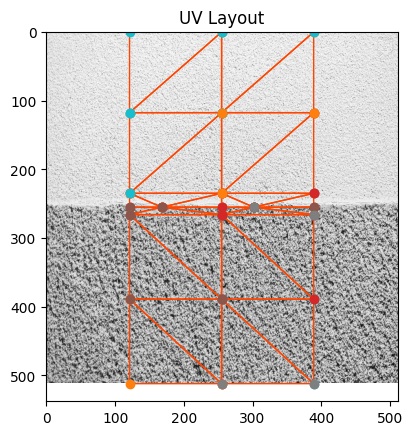

In [14]:
# Plot the triangles on the uv plane
# Scale the uv coordinates with the image dimensions
uvPoints = np.asarray(newMesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
print("UV coordinates: \n", len(uvPoints))
print("nr of vertices: \n", len(newMesh.vertices))
print("nr of triangles: \n" , len(newMesh.triangles))
plt.imshow(grayTexture, cmap='gray')

for i in range((int)(len(uvPoints)/3)):
        plt.fill(*zip(*uvPoints[3*i:3*i+3]), facecolor='none', edgecolor='orangered', linewidth=1)
        plt.scatter(*zip(*uvPoints[3*i:3*i+3]))
plt.title('UV Layout')
plt.show()

In [15]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.asarray(newMesh.vertices)[6:9])
o3d.visualization.draw_geometries([newMesh, pcd],mesh_show_wireframe=True)

## Object Segmentation

- use the texture blobs and adjacent faces region growing to segment the different objects

In [17]:
import segmentationtools as st
newMesh.textures = [o3d.geometry.Image(cv2.cvtColor(segmentedMappedTexture, cv2.COLOR_GRAY2RGB))]


In [18]:
st.show_geometries([mesh])

In [19]:
# split the mesh based on the texture color and adjacency

# open3d adjacency list to get neighbouring verteces